In [1]:
%matplotlib inline
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from albumentations import CLAHE, HorizontalFlip, Compose, HueSaturationValue, RandomBrightness, RandomContrast, Normalize, Resize
tqdm.pandas()

In [2]:
# https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
def crop_image1(img, tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img > tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img, tol=7):
    if img.ndim ==2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3], axis=-1)
    #         print(img.shape)
        return img


def load_ben_color(path, sigmaX=30):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (256, 256))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image , (0, 0) , sigmaX), -4, 128)
        
    return image

In [3]:
def imshow(index):
    fname = df.iloc[index].id_code
    label = df.iloc[index].diagnosis
    im = Image.open(f"../input/train/{fname}.png")
    width, height = im.size
    print(fname, width, height, label) 
    plt.imshow(np.asarray(im))

002c21358ce6 256 256 0 [133.26542664  71.25053406  32.63241577]


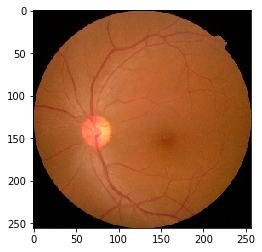

In [34]:
# df = pd.read_csv('../input/train.csv')
# index = random.randint(0, len(df))
index = 3
fname = df.iloc[index].id_code
label = df.iloc[index].diagnosis
im = np.load(f"../preprocessed/train_crop/{fname}.npy")
width, height = im.shape[0], im.shape[1]
print(fname, width, height, label, im.mean((0, 1))) 
plt.imshow(np.asarray(im))

002c21358ce6 1050 1050 0


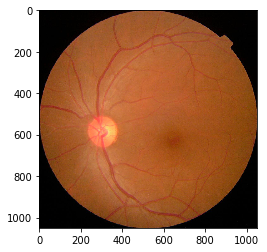

In [35]:
im = Image.open(f"../input/train/{fname}.png")
width, height = im.size
print(fname, width, height, label) 
plt.imshow(np.asarray(im))

### 画像サイズに依存はあるか

In [51]:
df['width'] = df.id_code.apply(lambda x: Image.open(f"../input/train/{x}.png").size[0])
df['height'] = df.id_code.apply(lambda x: Image.open(f"../input/train/{x}.png").size[1])

In [52]:
df['im_size'] = df.width.astype(str) + "_" + df.height.astype(str)
pd.crosstab(df.im_size, df.diagnosis)

diagnosis,0,1,2,3,4
im_size,,,,,
1050_1050,901,19,39,2,13
1467_1110,0,0,2,0,0
1476_1117,10,0,0,2,2
1504_1000,0,2,63,9,18
1844_1226,0,13,28,1,19
2048_1536,351,0,0,0,0
2144_1424,0,1,22,3,2
2146_1764,0,0,0,1,0
2416_1736,31,234,233,60,80


画像サイズvs診断に違いはある？　画像が大きいほど診断のseverityが高まっているが、これは確かに「病状が重い患者は設備の整った病院に行く→設備の整った病院では大きい画像を取ることが容易→画像サイズが大きいものほどseverityが高い」ということは言えそう。

ただ、ラベルノイズが激しいらしいことを考えると、単に「画像が大きいほど的確な判断がしやすいだけ→severityが高いデータが多い」と言えるかもしれない。

5188a8afa879 3216 2136 2


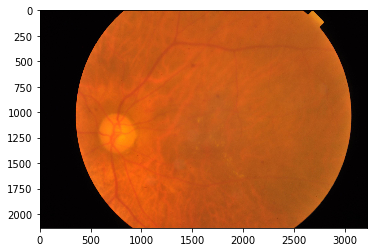

In [112]:
imshow(random.choice(df[(df.im_size == "3216_2136") & (df.diagnosis > 0)].index))

見る限り小さい画像（1050x1050)のほうが誤診断が多そうな感じがする。調べようがないが。。。

### 画像の輝度との依存

In [123]:
def get_value(fname):
    img = cv2.imread(fname)  # 画像の読み出し
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
    return img_hsv[:,:, 1].mean()

df["value"] = df.id_code.progress_apply(lambda x: get_value(f"../input/train/{x}.png"))

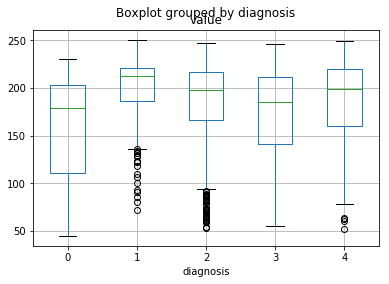

In [124]:
df.boxplot(by="diagnosis", column="value")

65cf08a0ecc8 640 480


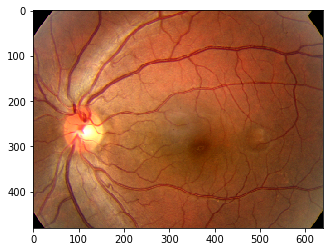

In [145]:
df = pd.read_csv('../input/sample_submission.csv')
index = random.randint(0, len(df))
fname = df.iloc[index].id_code
# label = df.iloc[index].diagnosis
im = Image.open(f"../input/test/{fname}.png")
width, height = im.size
print(fname, width, height) 
plt.imshow(np.asarray(im))

In [147]:
df['width'] = df.id_code.apply(lambda x: Image.open(f"../input/test/{x}.png").size[0])
df['height'] = df.id_code.apply(lambda x: Image.open(f"../input/test/{x}.png").size[1])

In [148]:
df['im_size'] = df.width.astype(str) + "_" + df.height.astype(str)
pd.crosstab(df.im_size, df.diagnosis)

diagnosis,0
im_size,
1050_1050,69
1467_1110,2
1476_1117,2
2048_1536,28
2146_1764,1
2416_1736,225
2588_1958,134
2592_1944,6
2896_1944,11


やはりテストデータのほうが画像が小さい

In [52]:
train_transform = Compose([
    HorizontalFlip(),
    #RandomBrightness(limit=0.3, p=1),
    # RandomContrast(limit=0.2, p=1),
    # Resize(256, 256),
])

cbd0870aa933 4


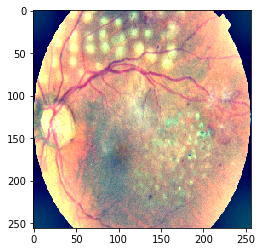

In [15]:
df = pd.read_csv('../input/train.csv')
index = random.randint(0, len(df))
fname = df.iloc[index].id_code
label = df.iloc[index].diagnosis
# im = Image.open(f"../input/train/{fname}.png")
im = load_ben_color(f"../input/train/{fname}.png")
print(fname, label) 
plt.imshow(np.asarray(im))

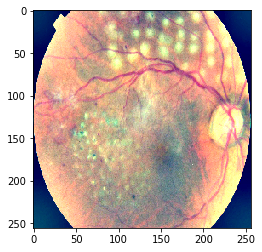

In [56]:
plt.imshow(train_transform(image=im)['image'])

In [166]:
# predとロスを比較してダメな画像を見つける。
df["pred"] = 0
y = df.diagnosis
mskf = KFold(n_splits=5, random_state=71)
splitter = mskf.split(df.id_code, y)
for i in range(5):
    _, te_ind = next(splitter)
    pred = np.load(f"../result/2019_07_11_03_57_58/val_preds_{i}.npy")
    print(len(pred), len(te_ind))
    #df.loc[te_ind, "pred"] = pred

704 733
704 733
704 732
704 732
704 732


In [165]:
len(y)

3662

### 画素平均との相関

In [14]:
im_info = np.stack(df.id_code.progress_apply(lambda x: np.array(Image.open(f"../input/train/{x}.png")).mean((0, 1))))

In [18]:
df[['r_mean', 'g_mean', 'b_mean']] = pd.DataFrame(im_info)

In [33]:
df[df.b_mean > 20]

,id_code,diagnosis,r_mean,g_mean,b_mean
3,002c21358ce6,0,133.362008,71.355011,32.730034
5,0083ee8054ee,4,93.385328,61.553562,20.410581
6,0097f532ac9f,0,55.733954,46.763753,47.475842
8,00b74780d31d,2,47.496994,50.049983,46.655694
11,00e4ddff966a,2,152.908342,97.406873,40.349405
14,0124dffecf29,1,147.744191,71.410041,39.312133
16,012a242ac6ff,2,114.119242,56.382584,22.051953
17,014508ccb9cb,0,67.249452,39.927959,23.305833
26,01f7bb8be950,0,61.220756,48.730090,41.149647
29,0231642cf1c2,0,58.741005,51.679361,41.979686
